In [25]:
# Dependencies
import tweepy
import numpy as np
import seaborn as sns
import pandas as pd
import json
import matplotlib.pyplot as plt
from matplotlib.dates import DayLocator, HourLocator, DateFormatter, drange
import matplotlib.dates as mdt
from datetime import datetime
from datetime import timezone
from datetime import date

today = date.today()

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Twitter API Keys
from config import (consumer_key,
                    consumer_secret,
                    access_token,
                    access_token_secret)

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [26]:
# Variables for holding all sentiments
compound_dict = {}
positive_dict = {}
negative_dict = {}
neutral_dict = {}
tweet_id_dict = {}
tweet_time_dict = {}
tweet_text_dict = {}


accounts = ['@BBCWorld', '@CBSNews', '@CNN', '@FoxNews', '@nytimes']
# Loop through accounts
for account in accounts:    
    
    # Target User Account
    target_user = account

    # Variables for holding sentiments
    compound_list = []
    positive_list = []
    negative_list = []
    neutral_list = []
    tweet_id = []
    tweet_time = []
    tweet_text = []

    # Loop through tweets 
    for i in range(1,21):

        # Get all tweets from home feed
        public_tweets = api.user_timeline(target_user, page=i)

        # Loop through all tweets
        for tweet in public_tweets:

            # Run Vader Analysis on each tweet
            positivity = analyzer.polarity_scores(tweet['text'])

            # Add each value to the appropriate list
            compound_list.append(positivity['compound'])
            positive_list.append(positivity['pos'])
            neutral_list.append(positivity['neu'])
            negative_list.append(positivity['neg'])

            # get tweet ID
            tweet_id.append(tweet['id_str'])

            # get tweet time
            tweet_time.append(tweet['created_at'])
            
            # get tweet text
            tweet_text.append(tweet['text'])
            
    # add lists to dictionaries
    compound_dict[account] = compound_list
    positive_dict[account] = positive_list
    negative_dict[account] = negative_list
    neutral_dict[account] = neutral_list
    tweet_id_dict[account] = tweet_id
    tweet_time_dict[account] = tweet_time
    tweet_text_dict[account] = tweet_text
    



In [27]:
# convert dictionaries to DataFrames
compound_DF = pd.DataFrame.from_dict(compound_dict)
positive_DF = pd.DataFrame.from_dict(positive_dict)
negative_DF = pd.DataFrame.from_dict(negative_dict)
neutral_DF = pd.DataFrame.from_dict(neutral_dict)
id_DF = pd.DataFrame.from_dict(tweet_id_dict)
time_DF = pd.DataFrame.from_dict(tweet_time_dict)
text_DF = pd.DataFrame.from_dict(tweet_text_dict)

In [28]:
# Create function to convert twitter times to a usable time format
def convert_time(time):
    converted_time = datetime.strptime(time, "%a %b %d %H:%M:%S %z %Y")
    return converted_time

In [29]:
# Convert all tweet times into datetime objects
for account in accounts:
    time_DF[account] = time_DF[account].apply(convert_time)

In [30]:
# Find oldest tweet
elder_tweet = [time_DF['@BBCWorld'].iloc[99],
               time_DF['@CBSNews'].iloc[99],
               time_DF['@CNN'].iloc[99],
               time_DF['@FoxNews'].iloc[99],
               time_DF['@nytimes'].iloc[99]]
# datetime.time.min
eldest_tweet = min(elder_tweet).to_pydatetime()

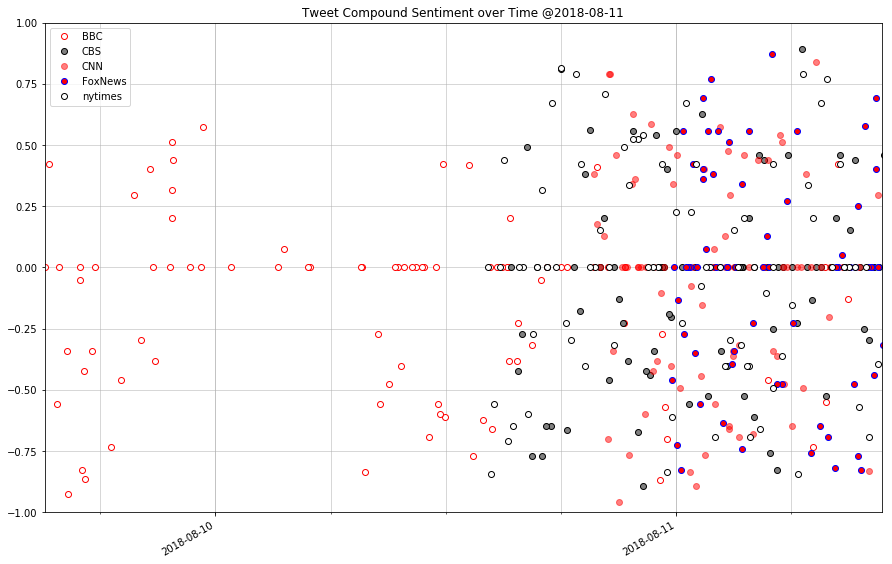

In [40]:
# set up scatterplot

# set plot size
fig = plt.figure(figsize=(15,10))

# create subplot object with 1 row, 1 column, and 1 plot
ax1 = fig.add_subplot(111)

# set plot height to  min/max compound score
plt.ylim(-1,1)

# set plot width to extend from now to the time of the oldest tweet to be plotted
plt.xlim(mdt.date2num(eldest_tweet),mdt.date2num(datetime.now()))

# set plots for each account using most recent 100 tweets
ax1.plot_date(mdt.date2num(time_DF['@BBCWorld'].head(100)), compound_DF['@BBCWorld'].head(100), 
              marker='o', markerfacecolor='white', markeredgecolor='red',  label='BBC')
ax1.plot_date(mdt.date2num(time_DF['@CBSNews'].head(100)), compound_DF['@CBSNews'].head(100),
              marker='o', markerfacecolor='grey', markeredgecolor='black',  label='CBS')
ax1.plot_date(mdt.date2num(time_DF['@CNN'].head(100)), compound_DF['@CNN'].head(100), 
              marker='o', markerfacecolor='red', markeredgecolor='red', alpha=0.5, label='CNN')
ax1.plot_date(mdt.date2num(time_DF['@FoxNews'].head(100)), compound_DF['@FoxNews'].head(100), 
              marker='o', markerfacecolor='red', markeredgecolor='blue', label='FoxNews')
ax1.plot_date(mdt.date2num(time_DF['@nytimes'].head(100)), compound_DF['@nytimes'].head(100), 
              marker='o', markerfacecolor='white', markeredgecolor='black', label='nytimes')

# set ticks to 6 hour intervals with labels for days on major ticks
ax1.xaxis.set_major_locator(DayLocator())
ax1.xaxis.set_minor_locator(HourLocator(np.arange(0, 25, 6)))
ax1.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.grid(which='both',linewidth=1,alpha=0.5)
ax1.fmt_xdata = DateFormatter('%a %b %d %H:%M:%S %z %Y')
fig.autofmt_xdate()

# set legend and title
plt.legend(loc="best")
plt.title(f'Tweet Compound Sentiment over Time @{today}')        
    
plt.show()

fig.savefig("Tweet Compound over Time.png")

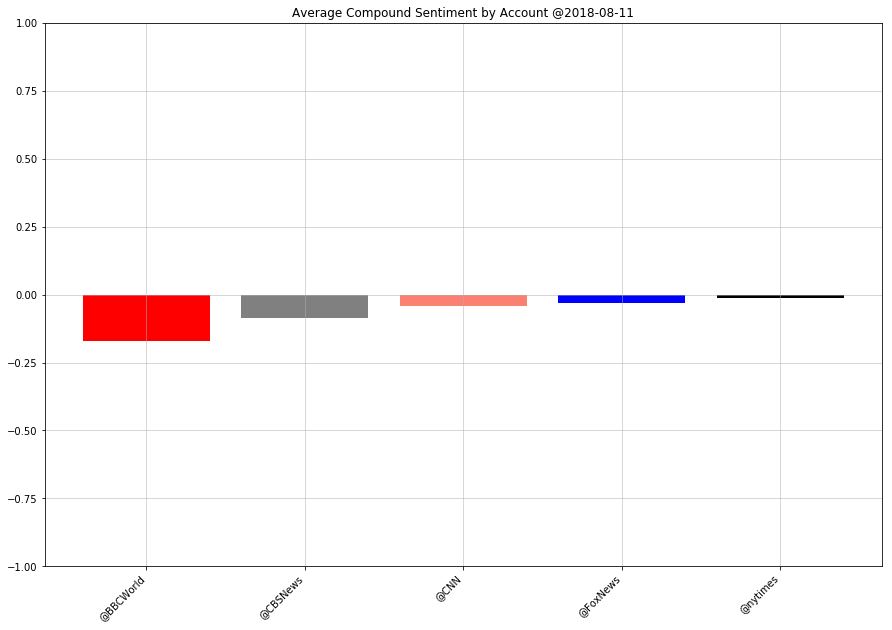

In [45]:
# Get average compound score of each twitter account over the last 100 tweets
CompoundMeans = compound_DF.head(100).mean()

# Set up bar chart
# set size of chart
plt.rcParams['figure.figsize'] = (15, 10)

# set up x ticks 
x_axis = np.arange(5)
tick_locations = []
for x in x_axis:
    tick_locations.append(x)
plt.xticks(tick_locations,accounts,rotation=45,ha='right')
plt.grid(which='both',linewidth=1,alpha=0.5)

# set plot height to  min/max compound score
plt.ylim(-1,1)

# plot data
figbar = plt.bar(x_axis,CompoundMeans,color=['red','grey','salmon','blue','black'])

# label plot
plt.title(f'Average Compound Sentiment by Account @{today}')        

plt.savefig("Avg Compound by Account.png")

plt.show()

In [33]:
# combine all DataFrames in to one
data_DF = compound_DF.join(positive_DF, how='outer', lsuffix='_compound', rsuffix='_positive')
data_DF = data_DF.join(negative_DF, how='outer', rsuffix='_negative')
data_DF = data_DF.join(neutral_DF, how='outer', rsuffix='_neutral')
data_DF = data_DF.join(id_DF, how='outer', rsuffix='_id')
data_DF = data_DF.join(time_DF, how='outer', rsuffix='_timestamp')
data_DF = data_DF.join(text_DF, how='outer', rsuffix='_fulltext')


In [34]:
# write full data to csv file
data_DF.to_csv('tweet_data.csv')

In [35]:
tweet_text_dict

{'@BBCWorld': ['Canada gun attack: Man charged after four killed in New Brunswick https://t.co/lXaAQ8Dmb4',
  "Germans held after flooding at 'unauthorised' French campsite https://t.co/7MLH7rNv0y",
  'Weedkiller cancer ruling: What do we know about glyphosate? https://t.co/8BmTNNJfoM',
  'Romania protests: Hundreds injured in anti-government rally https://t.co/thpOVhbINk',
  "Turkey's Erdogan condemns 'shameful' US over detained pastor https://t.co/wFlKicU2Hm",
  '"There\'s going to be racism until the day we die"\n\nWe asked African Americans in New Orleans what they think about… https://t.co/X88T580GVx',
  '"Leave immediately and keep far off"\n\nFlying over the disputed South China Sea islands in a US military plane… https://t.co/Lq0NlcR4bw',
  "Did Melania Trump's parents just take US citizenship with 'chain' migration?\n\nhttps://t.co/MyrsPQ83KY https://t.co/CiY0xwq6cN",
  'Glyphosate ruling: Weedkiller safe, says Bayer, despite cancer payout https://t.co/gWhNwM2ISC',
  "How the 